# ECG - Electrocardiography

This notebook illustrates how we can search a large time series of over 20 million data points using the mass2_batch algorithm. Electrocardiography measures heart beats through attaching sensors to the skin of an individual. This particular data set is sampled at 250 samples per second containing 22 hours and 23 minutes of data points; 110,087 heart beats. This individual is an 84 year old woman.

The dataset original came from the UCR Suite example illustrating the LB_Keogh algorithm for DTW.

https://www.cs.ucr.edu/~eamonn/UCRsuite.html

They found a series, used as the query, consisting of a a PVC - premature ventricular contraction on an educational poster.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import mass_ts as mts

%matplotlib inline

In [2]:
import tarfile

def load_file(archive, fp):
    """
    Utility function that reads a tar file directly into a numpy array.
    
    Parameters
    ----------
    archive : str
        The archive file to read.
    fp : str
        The file path of the file to read relative to the archive.
    
    
    Returns
    -------
    None if data reading failed or the numpy array of values.
    """
    data = None
    with tarfile.open(archive) as a:
        f = a.extractfile(dict(zip(a.getnames(),a.getmembers()))[fp])
        data = pd.read_csv(f, header=None, names=['reading', ])['reading'].values
    
    return data

# Load Data

In [3]:
%%time
ecg = load_file('ecg.tar.gz', 'ecg.txt')
ecg_query = load_file('ecg_query.tar.gz', 'ecg_query.txt')

CPU times: user 4.95 s, sys: 376 ms, total: 5.33 s
Wall time: 5.32 s


In [4]:
print('ECG data length is {:,}'.format(len(ecg)))
print('Query length is {:,}'.format(len(ecg_query)))

ECG data length is 20,140,000
Query length is 421


# Visualize

Here is a sample of what the data looks like.

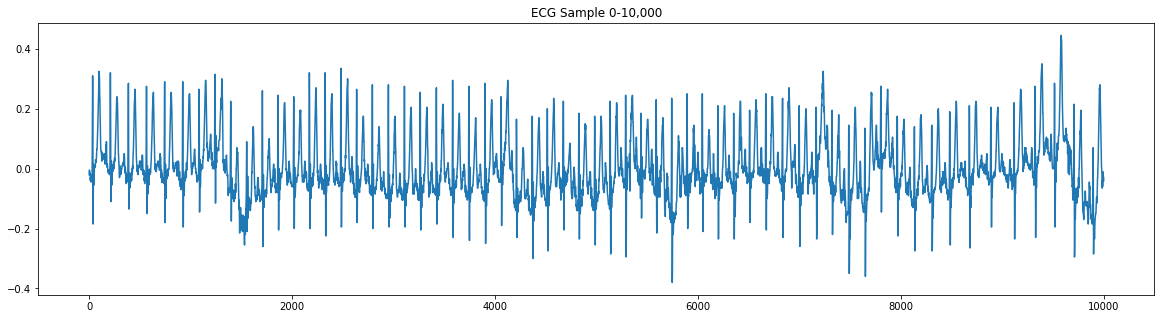

In [5]:
sample = ecg[0:10000]
plt.figure(figsize=(20,5))
plt.plot(range(len(sample)), sample)
plt.title('ECG Sample 0-10,000')
plt.show()

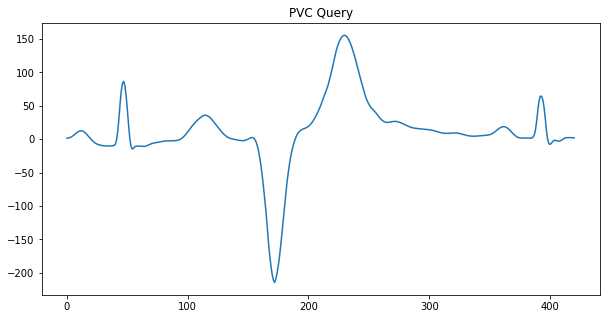

In [6]:
plt.figure(figsize=(10,5))
plt.plot(range(len(ecg_query)), ecg_query)
plt.title('PVC Query')
plt.show()

# Compute Top Matches

Here we compute the top 5 matches based on the query illustrating both single-threaded mode and multi-threaded mode.

In [7]:
# total number of matches we want returned
top_matches = 5

# length of the subsequence to search in batch processing.
# note that this has an impact on memory usage
batch_size = 10000

## Single-threaded

In [8]:
%%timeit
best_indices, best_dists = mts.mass2_batch(ecg, ecg_query, batch_size=batch_size, top_matches=top_matches)

56.7 s ± 5.43 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Multi-threaded

Run the same logic, but with 4 cpu threads.

In [9]:
# run same task with 4 cpu threads
n_jobs = 4

In [10]:
%%timeit
best_indices, best_dists = mts.mass2_batch(ecg, ecg_query, batch_size=batch_size, top_matches=top_matches, n_jobs=n_jobs)

16.3 s ± 844 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [11]:
best_indices, best_dists = mts.mass2_batch(ecg, ecg_query, batch_size=batch_size, top_matches=top_matches, n_jobs=n_jobs)

The multi-threaded version is 2X faster than the single threaded version.

# Visualize Top Matches

The plot below shows the top 5 matches given our query. The first plot is the query we searched for.

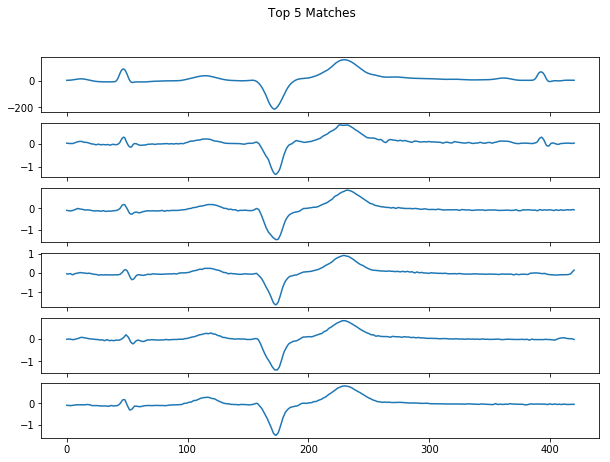

In [12]:
# Plot the query with top matches
fig, axes = plt.subplots(top_matches + 1,1,sharex=True,figsize=(10,7))
axes[0].plot(np.arange(len(ecg_query)), ecg_query)

for ax, idx in zip(axes[1:], best_indices):
    ax.plot(np.arange(len(ecg_query)), ecg[idx:idx+len(ecg_query)])
    #ax.set_ylabel('Index {}'.format(idx), size=12)

plt.suptitle('Top 5 Matches')
plt.show()